<div style="background-color:	#674589; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Huisprijzen voorspellen</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
3. [H3: Fully-connected neuraal netwerk](#3.0)
4. [H4: Convolutioneel neuraal netwerk](#4.0)
    - [&sect;4.1: Moet worden aangepast](#4.1)
5. [H5: Transfer Learning](#5.0)
    - [&sect;5.1: Het model](#5.1)
    - [&sect;5.2: Modelarchitectuur](#5.2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\bosch\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#674589; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#674589; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: EDA DataFrame</h3>

In [2]:
train = pd.read_csv("train.csv")
train.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


In [4]:
train.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
Price        0
dtype: int64

In [5]:
train.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Het train DataFrame
1. Het is een Dataframe
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

In [6]:
test = pd.read_csv("test.csv")
test.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


In [8]:
test.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


In [9]:
test.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
dtype: int64

Het test DataFrame
1. Het is een DataFrame
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

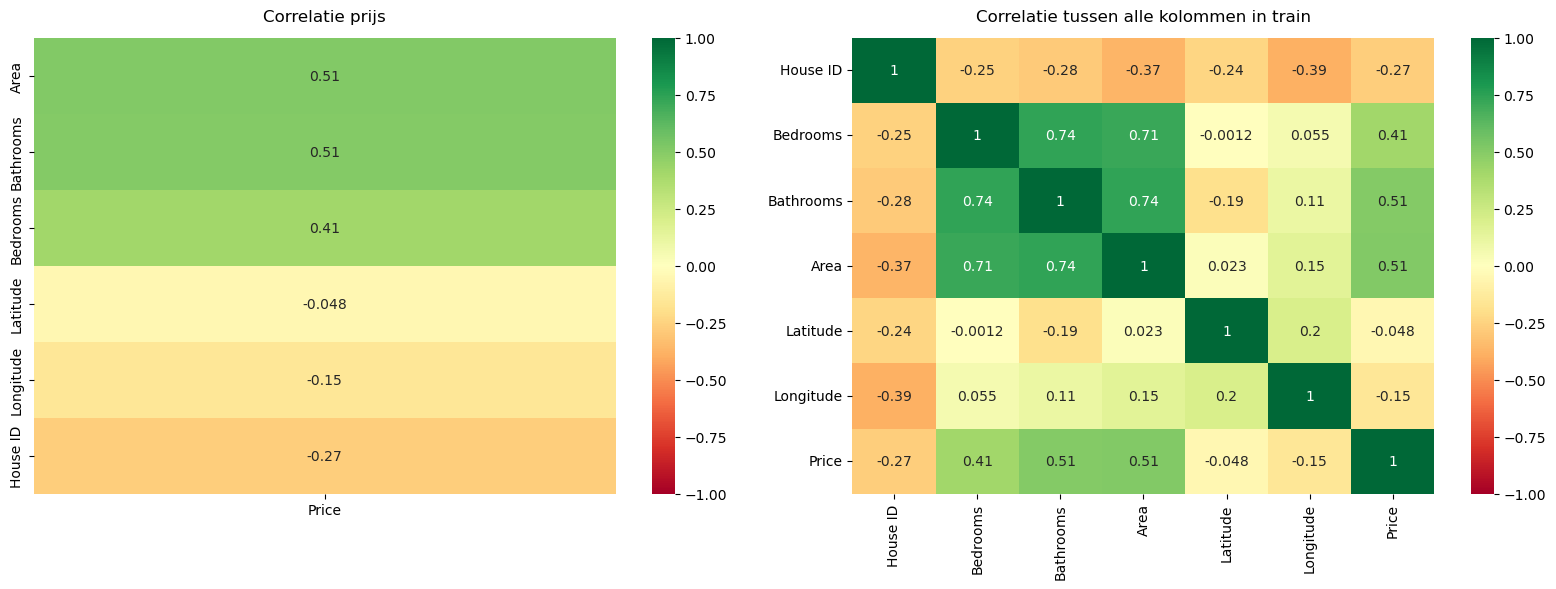

In [10]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['Price']].drop("Price").sort_values(by='Price', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie prijs', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

We zien in de heatmaps hierboven dat er een aantal kolommen zijn die wat meer invloed hebben op het voorspellen van de huisprijzen. Zo hebben de kolom "Area", "Bathrooms" en "Bedrooms" de meeste invloed. Ook zien we dat er een hoge correlatie is tussen de kolommen "Bathrooms" en "Bedrooms" en tussen de kolommen "Area" en "Bedrooms". Dit zijn voor ons dus belangrijke kolommen om te gebruiken voor ons latere Deep Learning model.

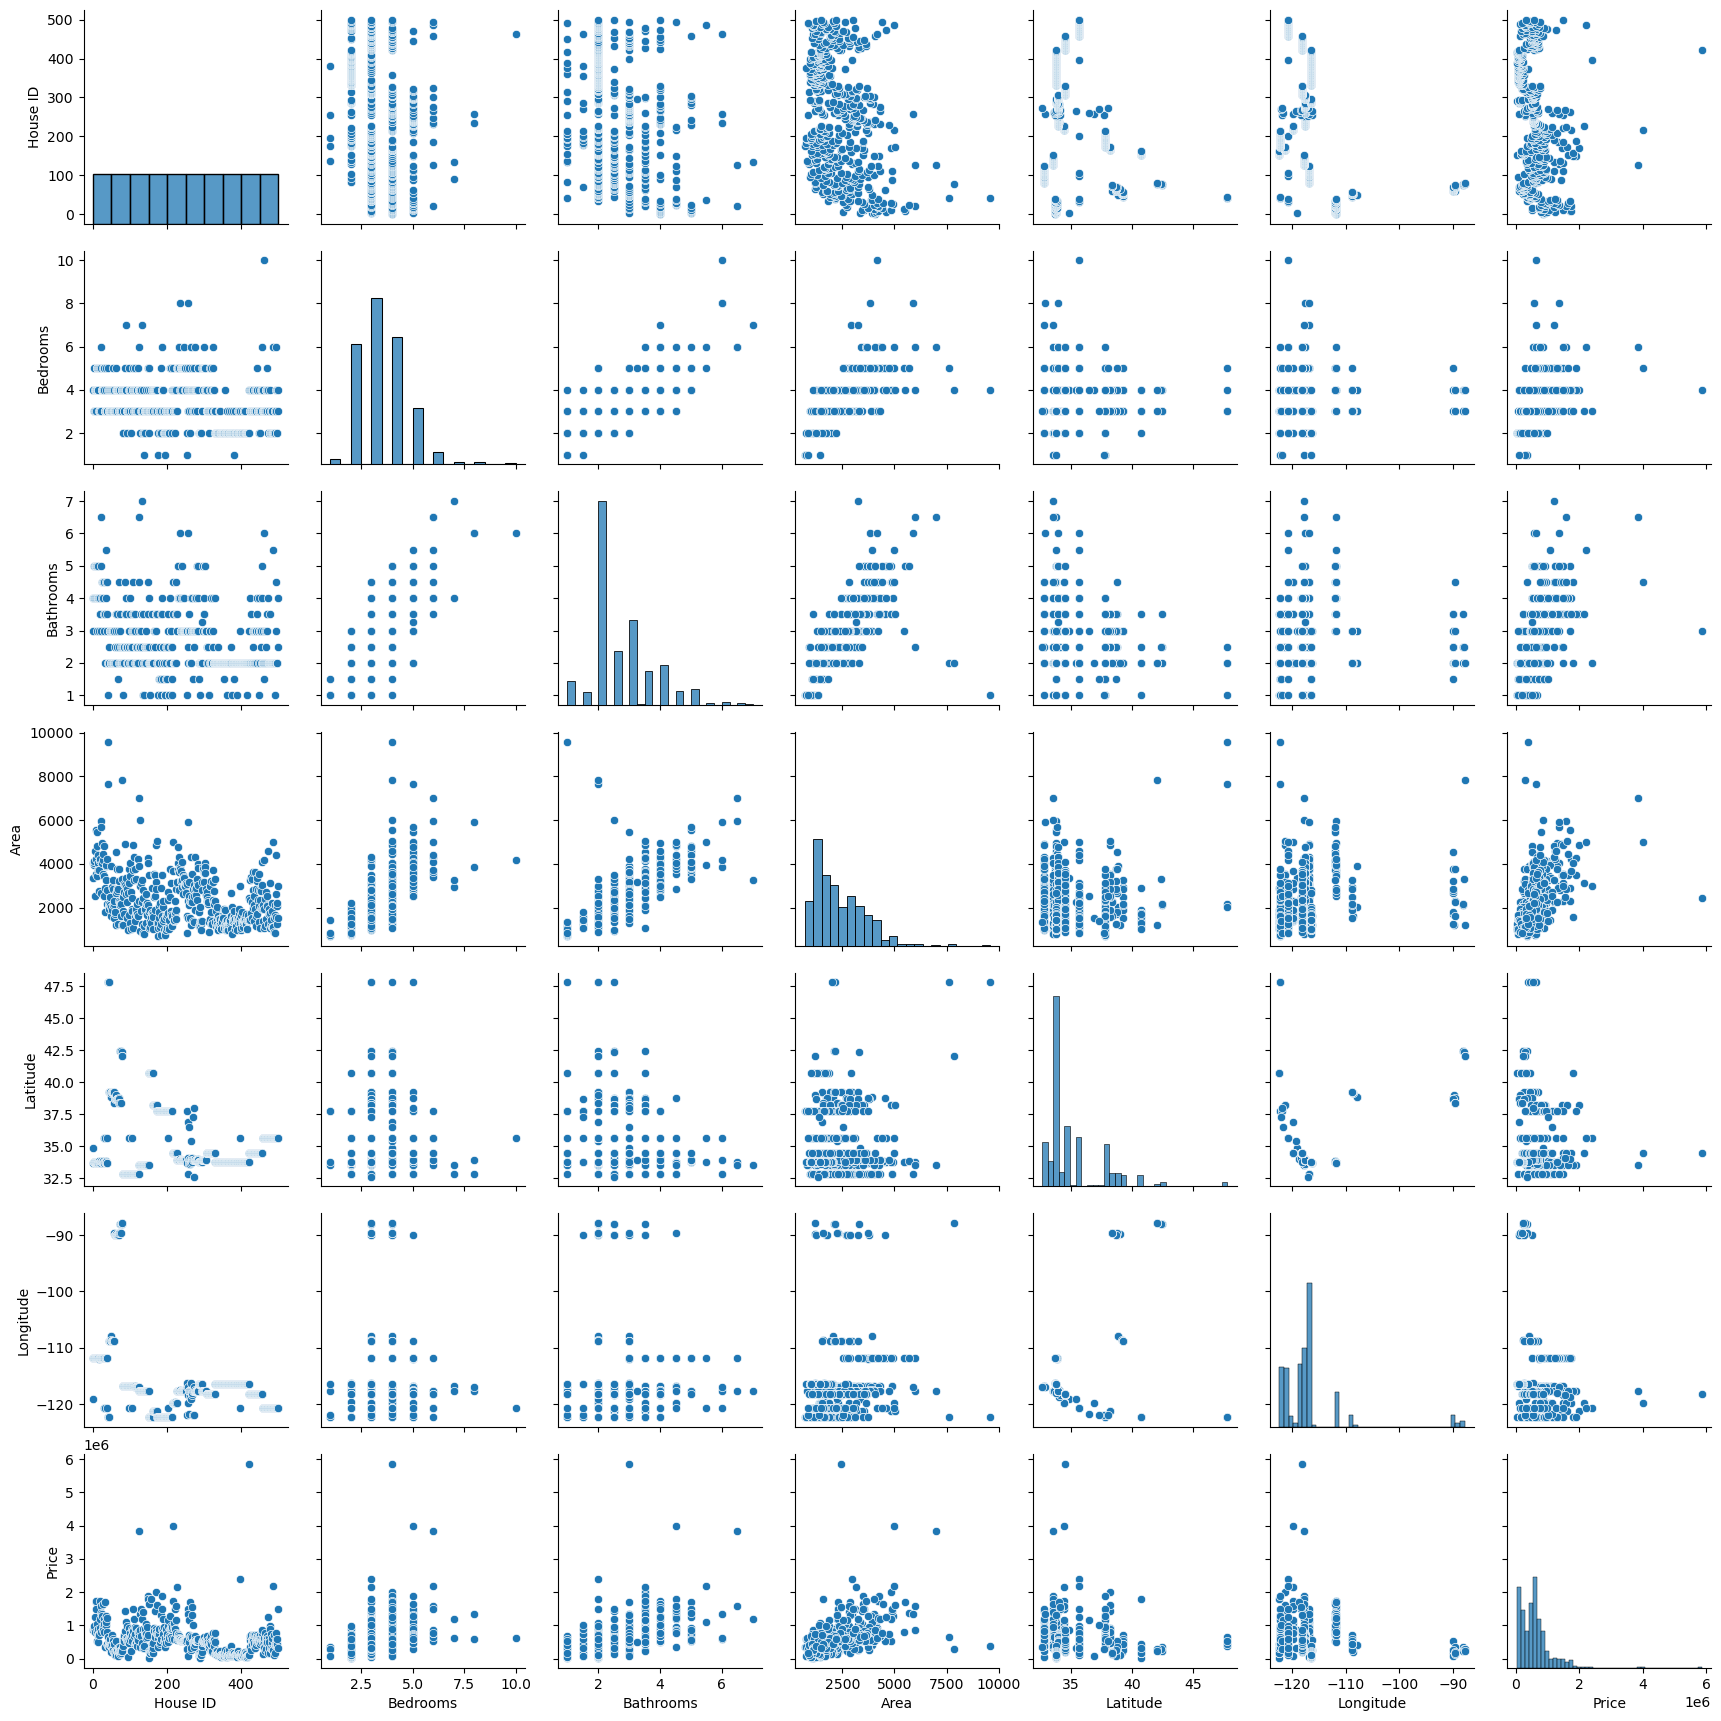

In [11]:
sns.pairplot(train)
plt.show()

Hierboven geven we een visualisatie van de correlaties tussen alle individuele kolommen. Hier zien wij weer de sterkste correlatie terug tussen de drie kolommen "Area", "Bedrooms" en "Bathrooms".

We gaan nu wat dieper kijken naar een aantal kolommen om te kijken naar mogelijke uitschieters.

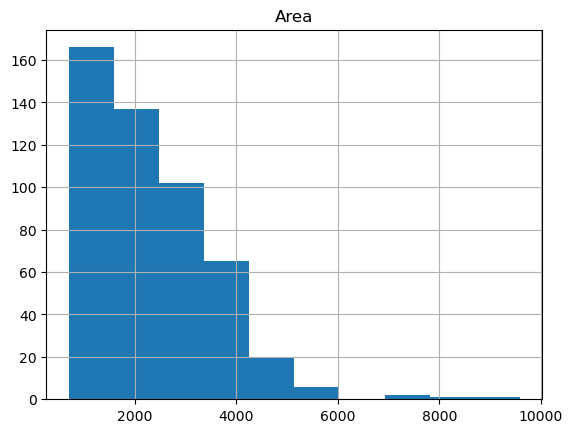

In [12]:
train.hist("Area")
plt.show()

We zien enkele uitschieters wanneer wij kijken naar de "Area" kolom. Wanneer wij de regels weergeven van de huizen met een oppervlakte van hoger dan 6000 vinden wij 4 huizen. Wij zien hier dat het grootste huis helemaal niet duur is. Het huis is nog net geen 4 ton, maar heeft wel een oppervlakte van bijna 10.000 square feet.

In [13]:
train[train["Area"] > 6000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
40,41,4,1.0,9583,47.7918,-122.2243,395000
41,42,5,2.0,7627,47.7918,-122.2243,638940
78,79,4,2.0,7841,42.0467,-87.8859,299000
125,126,6,6.5,7000,33.5145,-117.7084,3850000


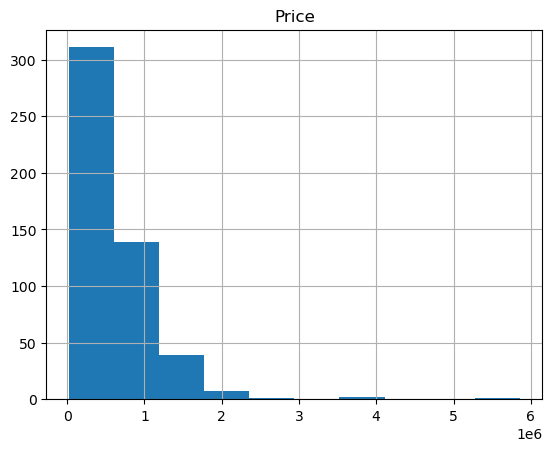

In [14]:
train.hist("Price")
plt.show()

Ook vinden wij een paar hoge uitschieters bij de "Price" kolom. Wanneer wij gaan kijken naar de rijen die hierbij horen valt het op dat het huis met de hoogste prijs van bijna 6 miljoen helemaal niet zo'n groot oppervlakte heeft. Dit valt op, vooral omdat wij net hebben gezien dat het grootste huis die 4 keer kleiner is wel 15 keer duurder is. Het zou te maken kunnen hebben met de ligging, dus dat gaan wij later verder onderzoeken.

In [15]:
train[train["Price"] > 3000000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
125,126,6,6.5,7000,33.5145,-117.7084,3850000
216,217,5,4.5,5000,34.4453,-119.8025,4000000
421,422,4,3.0,2454,34.4835,-118.1959,5858000


Ook nemen wij een kijkje naar de huizen die meer dan 6 slaapkamers hebben. Dit zijn er maar een aantal en de oppervlaktes liggen dicht bij elkaar. Wat wel opvalt is de prijzen die erg uiteen liggen.

In [16]:
train[train["Bedrooms"] > 6]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
89,90,7,4.0,2929,32.8282,-116.7543,625000
133,134,7,7.0,3265,33.5145,-117.7084,1200000
234,235,8,6.0,3849,33.9208,-117.6096,580000
256,257,8,6.0,5900,32.8562,-116.9201,1350000
461,462,10,6.0,4188,35.6406,-120.7003,629000


Aan het begin van onze EDA hebben wij gezien dat er een aantal kolommen het meeste invloed hebben op het voorspellen van de huisprijs. Deze gaan wij wat beter bekijken door naar de groepsgemiddeldes te kijken.

In [17]:
bedrooms = train.groupby("Bedrooms")["Price", "Area"].mean()
bedrooms

C:\Users\bosch\AppData\Local\Temp\ipykernel_20884\382465525.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bedrooms = train.groupby("Bedrooms")["Price", "Area"].mean()


,Price,Area
Bedrooms,,
1,2.828180e+05,909.400000
2,2.326775e+05,1303.196721
3,5.980077e+05,2045.183432
4,7.887358e+05,2970.038760
5,8.186575e+05,3775.263158
6,1.180959e+06,4399.538462
7,9.125000e+05,3097.000000
8,9.650000e+05,4874.500000
10,6.290000e+05,4188.000000


Het valt ons op dat de oppervlaktes van de huizen veelal toenemen hoe meer slaapkamers er aanwezig zijn. Bij de prijs is dit een ander geval. Wij zien het geleidelijk toenemen tot hij zijn maximum heeft bereikt bij 6 slaapkamers. Hier telt hij een gemiddelde prijs van wel 1 miljoen. Hierna neemt het weer af.

In [18]:
train["Bedrooms"].value_counts()

3     169
4     129
2     122
5      57
6      13
1       5
7       2
8       2
10      1
Name: Bedrooms, dtype: int64

Wanneer wij kijken naar de aantallen die voorkomen met meer dan 6 slaapkamers zien wij dat er aan veel kleiner aantal aan huizen is. Daarom is het niet betrouwbaar om deze te serieus te nemen tijdens het voorspellen van de prijs, omdat er bijvoorbeeld 1 huis is met 10 slaapkamers en 0 huizen met 9 slaapkamers.

In [19]:
bathrooms = train.groupby("Bathrooms")["Price", "Area"].mean()
bathrooms

C:\Users\bosch\AppData\Local\Temp\ipykernel_20884\533526990.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bathrooms = train.groupby("Bathrooms")["Price", "Area"].mean()


,Price,Area
Bathrooms,,
1.00,3.608495e+05,1323.750000
1.50,5.223000e+05,1346.846154
2.00,3.371919e+05,1640.338164
2.50,6.214254e+05,2286.727273
3.00,6.996374e+05,2770.383721
3.25,5.150000e+05,3149.000000
3.50,1.066022e+06,3284.771429
4.00,8.905609e+05,3619.170732
4.50,1.367707e+06,4168.857143


Wij doen het zelfde voor de "Bathroom" kolom. Hierin stijgt ook de oppervlaktes van de huizen na mate er meer badkamers aanwezig zijn. De prijs is echter redelijk instabiel. Ook is het gemiddelde niet heel betrouwbaar, omdat de data niet goed verdeeld is. Zo zijn er 207 huizen met 2 badkamers en maar 3 huizen met 6 badkamers. Dit is waarschijnlijk dan ook het geval dat er niet veel huizen zijn met zo veel badkamers.

In [20]:
train["Bathrooms"].value_counts()

2.00    207
3.00     86
2.50     55
4.00     41
3.50     35
1.00     24
5.00     16
4.50     14
1.50     13
6.00      3
6.50      2
5.50      2
7.00      1
3.25      1
Name: Bathrooms, dtype: int64

Het valt ons op dat er ook halve waardes zijn voor de kolom "Bathrooms". Wij gaan er van uit dat dit badkamers zijn waar alleen een WC aanwezig is.

<a name='2.2'></a>
<h3>&sect;2.2: EDA Foto's</h3>

In [21]:
from pathlib import Path
import tensorflow as tf

# Update the image directory path
img_directory = "Train"
train = pd.read_csv('train.csv')  # adjust filename and path as necessary

# Load images without considering the directory-generated labels
image_size = (1024, 1024)
batch_size = 4

# This loads the images but ignores the labels
image_dataset = tf.keras.utils.image_dataset_from_directory(
    img_directory,
    label_mode=None,  # Ignore directory-based labels
    image_size=image_size,
    batch_size=batch_size
)

# Extract file paths from the dataset
image_file_paths = image_dataset.file_paths

# Extract only file ID without extension from file paths
image_hids = [Path(image_file_path).stem for image_file_path in image_file_paths]
image_hids_int = [int(house_id) for house_id in image_hids]

labels = [train.loc[train['House ID'] == houseid, 'Price'].values for houseid in image_hids_int]

# Convert the list of labels into a TensorFlow dataset
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)

# Combine the original image dataset with the labels dataset
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

Found 500 files belonging to 1 classes.


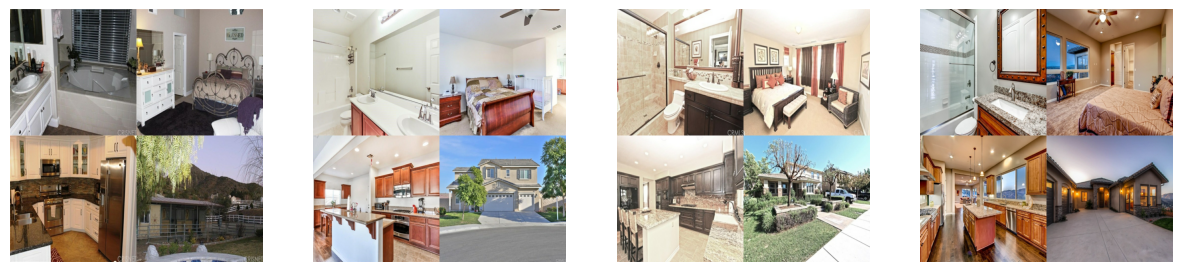

In [22]:
import matplotlib.pyplot as plt

# Convert the image dataset to an iterable format
image_iterator = iter(image_dataset)

# Get one batch of images
batch_images = next(image_iterator)

num_images_to_display = 4  # Change this to display more images

# Display a grid of images
plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#674589; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Fully-connected neuraal netwerk</strong></h2>
</div>


In [21]:
from sklearn.model_selection import train_test_split
X = train.drop(columns=["Price"])
y = train["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creëren van model

In [22]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, optimizers
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(input_shape,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="relu"))

# Model architectuur

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11777 (46.00 KB)
Trainable params: 11777 (46.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(optimizer="sgd", loss="mean_absolute_percentage_error")

In [25]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 2s 51ms/step - loss: 99.9538 - val_loss: 99.9359
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 99.9184 - val_loss: 99.8962
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 99.8760 - val_loss: 99.8497
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 99.8247 - val_loss: 99.7924
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 99.7600 - val_loss: 99.7182
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 99.6736 - val_loss: 99.6145
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 99.5473 - val_loss: 99.4560
Epoch 8/100
10/10 [==============================] - 0s 11ms/step - loss: 99.3462 - val_loss: 99.1909
Epoch 9/100
10/10 [==============================] - 0s 10ms/step - loss: 98.9896 - val_loss: 98.6881
Epoch 10/100
10/10 [==============================] - 0s 10ms/step - loss: 98.2453

# Visualisatie Loss 

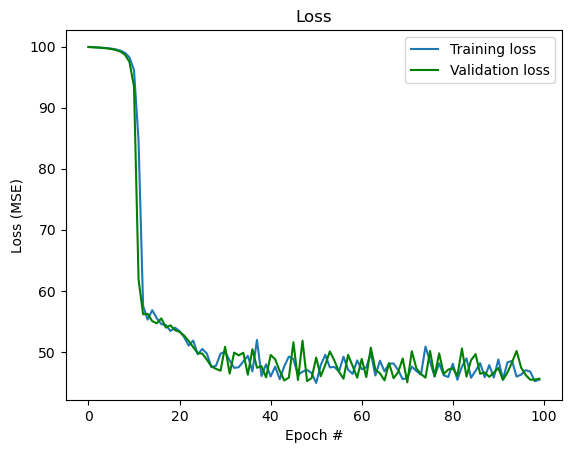

In [26]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()

In [27]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 56.5117


56.51170349121094

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#674589; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Convolutioneel neuraal netwerk</strong></h2>
</div>

In [24]:
num_samples = sum(1 for _ in final_dataset)
val_size = int(0.2 * num_samples)  # 20% of the dataset for validation

# Split the dataset into training and validation sets
val_dataset = final_dataset.take(val_size)
train_dataset = final_dataset.skip(val_size)

In [25]:
img_height, img_width = 256, 256
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

In [26]:
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
from tensorflow.keras import layers

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_percentage_error')

num_epochs = 15
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/15
1/8 [==>...........................] - ETA: 34:40 - loss: nan

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#674589; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Transfer Learning</strong></h2>
</div>

<a name='5.1'></a>
<h3>&sect;5.1: Het model</h3>

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model without top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom regression layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)  # Output layer for regression

# Create the transfer learning model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_model.compile(optimizer=opt, loss='mape')

# Print model summary
transfer_model.summary()

# Train the model
history = transfer_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[stop_early])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']        

NameError: name 'train_dataset' is not defined

In [46]:
#!pip install --user pydot graphviz

     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [24]:
import os
import pydot

# Specificeer het pad naar de map met 'dot'-executable
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

<a name='2.1'></a>
<h3>&sect;5.1: Modelarchitectuur</h3>

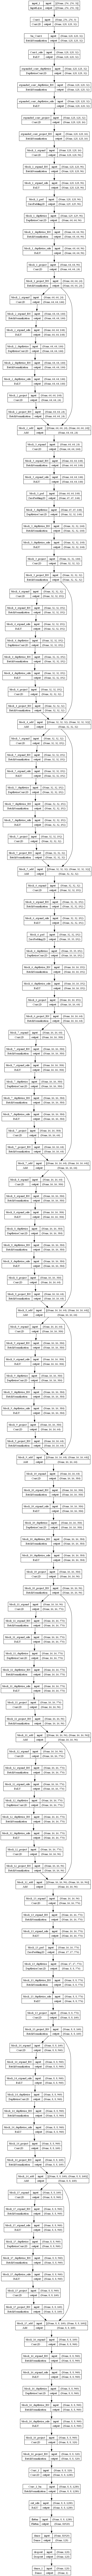

In [25]:
import keras

tf.keras.utils.plot_model(transfer_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)